<a href="https://colab.research.google.com/github/armandossrecife/my_validation3/blob/main/analise_issues_cassandra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Piloto 1 - Análise dos issues do Cassandra

3a. Rodada (pós reunião)

**Cenário1:** Issues que aparecem nos commits com classes críticas

Período: from 2/03/2009 to 4/10/2023

Commits: 29230

Issues: 18635

Repositório Apache Cassandra: https://github.com/apache/cassandra

Issue Tracker: https://issues.apache.org/jira/projects/CASSANDRA

# Processo de coleta, análise e interpretação dos resultados


**1.   Coleta dos dados**

Definição da nossa população de interesse

- população de commits: os commits do repositório "Apache Cassandra" no GitHub entre as datas especificadas que possuam classes críticas.
- população de issues: os issues do Issue Tracker do "Apache Cassandra" entre as datas especificadas que estão relacionados aos commits com classes críticas

**2.   Seleção da amostra**

Seleção de uma parte dos issues suspeitos que serão analisados.

- uma amostra aleatória de issues em vez de toda a população de issues, devido a necessidade de realizar inspeção manual nos issues e esta tarefa "consome muito tempo".
- Tempo médio de inspeção manual de issues: 40 issues por dia.

**3.   Cálculo da amostra**

Baseado em uma variável aleatória contínua normal do [ScyPY](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html)

- Baseado nos parâmetros: confidence_level = 0.95, margin_of_error = 0.05, population_proportion = 0.5 e population_size = len(quantidade_de_issues_suspeitos)
- sample_size = calculate_sample_size(confidence_level, margin_of_error, population_proportion, population_size)
- norm.ppf(): variável aleatória contínua normal

**4. Análise estatística**

Após a coleta de dados, vamos realizar as análises estatísticas dos issues para checar se os issues suspeitos indicam impacto arquitetural.


**5. Visualização dos dados**

Vamos criar os gráficos e visualizações sobre os issues suspeitos

**6. Interpretação dos resultados**

Vamos interpretar os resultados das análises estatísticas e tirar nossas conclusões sobre os issues suspeitos.

## Perguntas

Primeira parte:

Q1. Quais são as classes críticas?

Q2. Quais são os commits que possuem classes críticas?

Q3. Quais são os issues que aparecem nos commits que possuem classes críticas?

Segunda parte:

Q4. Os issues da Q3 possuem impacto arquitetural?

Q5. Quanto (%) dos issues da Q3 possuem impacto arquitetural?

### Funções de apoio

In [1]:
import pandas as pd
import regex as re
import scipy.stats as stats
import random
import tqdm
import os
import matplotlib.pyplot as plt

def find_all_issues_cassandra(input_string: str) -> list[str]:
    # Try to find all Cassandra issue ID patterns in the input string
    matches = re.findall(r'(CASSANDRA-\d+)', input_string)
    set_matches = set(matches)
    list_unique_matches = list(set_matches)

    # Return the list of matched Cassandra issue IDs
    return list_unique_matches

def calculate_sample_size(confidence_level, margin_of_error, population_proportion, population_size):
    # Calculate the Z-score for the given confidence level
    z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)

    # Calculate the sample size formula
    sample_size = ((z_score**2) * population_proportion * (1 - population_proportion)) / (margin_of_error**2)

    # Adjust for finite population
    if population_size:
        sample_size = sample_size / (1 + ((sample_size - 1) / population_size))

    return int(sample_size)

def get_max_n_chars(text, max_n):
  text_length = len(text)
  if text_length <= max_n:
    return text
  else:
    return text[:max_n]

def create_new_file(filename, dir_name, issue_type, summary, description, status, comments):
  try:
    print('Creating a new text file...')
    print(f'Create file {filename} in {dir_name}')
    filename = dir_name + '/' + filename

    if issue_type is None:
      issue_type = ''
    if summary is None:
      summary = ''
    if description is None:
      description = ''
    if status is None:
      status = ''
    if comments is None:
      comments = ''

    with open(filename, mode='w') as f_issue:
      f_issue.write(f'issue_type: {issue_type} \n')
      f_issue.write(f'summary: {summary} \n')
      f_issue.write(f'description: {get_max_n_chars(text=description, max_n=1000)} \n')
      f_issue.write(f'status: {status} \n')
      f_issue.write(f'comments: {get_max_n_chars(text=comments, max_n=4000)} \n')
    print(f'File {filename} created with success!')

  except Exception as ex:
    print(f'Erro: {str(ex)}')


In [2]:
def load_itens_to_list(my_file):
  my_list = []
  with open(my_file, mode='r') as f_temp:
    for linha in f_temp:
      linha = linha.strip()
      my_list.append(linha)
  return my_list

def generate_relacao_commits_issues(filtered_df):
  relacao_commit_lista_issues = []
  for index in filtered_df.index:
    if len(find_all_issues_cassandra(input_string=filtered_df.msg[index]))>0:
      #print(filtered_df.msg[index])
      elemento = filtered_df.hahs[index], find_all_issues_cassandra(input_string=filtered_df.msg[index])
      relacao_commit_lista_issues.append(elemento)

  l_hash, l_issues = [], []
  for each in relacao_commit_lista_issues:
    issues_separados_por_virgula = ",".join(each[1])
    l_hash.append(each[0])
    l_issues.append(issues_separados_por_virgula)



  dict_relacao_commit_issues = {
    'hahs':l_hash,
    'lista_issues':l_issues
  }

  df_relacao_commit_issues = pd.DataFrame(dict_relacao_commit_issues)
  return df_relacao_commit_issues

def show_pie(my_df, my_field, my_title):
  type_counts = my_df[my_field].value_counts().sort_values(ascending=False)
  type_percentages = type_counts / type_counts.sum() * 100

  plt.pie(type_percentages, labels=type_counts.index, autopct="%.1f%%")
  plt.title(my_title)
  plt.show()

def show_pie_yes_no(my_df, my_field, my_title):
  type_counts = my_df[my_field].value_counts().sort_values(ascending=False)
  type_percentages = type_counts / type_counts.sum() * 100

  plt.pie(type_percentages, labels=type_counts.index, autopct="%.1f%%")
  plt.title(my_title)
  plt.show()
  print(f'Total: {type_counts[0] + type_counts[1]} - Yes: {type_counts[1]}, No: {type_counts[0]}')

### Importa o dataset inicial

In [3]:
!wget https://raw.githubusercontent.com/armandossrecife/my_validation2/main/commits_arquivos_criticos.xlsx
!wget https://raw.githubusercontent.com/armandossrecife/my_validation2/main/issues_in_commits_arquivos_criticos.xlsx
!wget https://raw.githubusercontent.com/armandossrecife/my_validation2/main/commits_arquivos_critico_e_issues.txt
!wget https://raw.githubusercontent.com/armandossrecife/my_validation2/main/issues_inspected_c1.xlsx
!wget https://raw.githubusercontent.com/armandossrecife/my_validation2/main/my_inspection.zip

--2023-11-01 15:38:53--  https://raw.githubusercontent.com/armandossrecife/my_validation2/main/commits_arquivos_criticos.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13233731 (13M) [application/octet-stream]
Saving to: ‘commits_arquivos_criticos.xlsx’

commits_arquivos_cr 100%[===================>]  12.62M  --.-KB/s    in 0.1s    

2023-11-01 15:38:53 (120 MB/s) - ‘commits_arquivos_criticos.xlsx’ saved [13233731/13233731]

--2023-11-01 15:38:54--  https://raw.githubusercontent.com/armandossrecife/my_validation2/main/issues_in_commits_arquivos_criticos.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199

# Primeira Parte

## Q1. Classes críticas

From [ATDCodeAnalyzer](https://github.com/mining-software-repositories/cassandra)

São classes impactadas por ATD identificadas pelo ATDCodeAnalyzer

In [4]:
lista_classes_criticas = ['StorageService.java', 'ColumnFamilyStore.java', 'DatabaseDescriptor.java', 'CompactionManager.java', 'StorageProxy.java', 'SSTableReader.java', 'Config.java', 'CassandraDaemon.java', 'SelectStatement.java', 'SinglePartitionReadCommand.java', 'NodeProbe.java', 'MessagingService.java']
print(len(lista_classes_criticas), lista_classes_criticas)

12 ['StorageService.java', 'ColumnFamilyStore.java', 'DatabaseDescriptor.java', 'CompactionManager.java', 'StorageProxy.java', 'SSTableReader.java', 'Config.java', 'CassandraDaemon.java', 'SelectStatement.java', 'SinglePartitionReadCommand.java', 'NodeProbe.java', 'MessagingService.java']


## Q2. Commits com classes críticas

From [My_validation](https://www.github.com/armandossrecife/my_validation)

São os commits que possuem pelo menos uma classe crítica em seu registro, ou seja, se um commit modificar classes críticas, ele será relevante para a nossa análise.

**4522** commits

In [5]:
df_commits_classes_criticas = pd.read_excel('commits_arquivos_criticos.xlsx')
df_commits_classes_criticas

,hahs,msg,m_files,date,lines,files,diff_files,diff_modified_files
0,1f91e99223b0d1b7ed8390400d4a06ac08e4aa85,git-svn-id: https://svn.apache.org/repos/asf/i...,"['DatabaseDescriptor.java', 'ColumnFamilyStore...",2/3/2009,74502,344,"[\n {\n ""DatabaseDescriptor.java"": ""...","[\n ""Binary files /dev/null and b/lib/JSAP-..."
1,cf56f8f3acbeac0ddff9ee3131ad7abe2a919ba3,Add build script and make sure it works\n\ngit...,['StorageService.java'],2/3/2009,156,4,"[\n {\n ""StorageService.java"": ""@@ -...","[\n ""@@ -0,0 +1,133 @@\n+<?xml version=\""1...."
2,5bea7e1772e9fd042b10abebb1e0c78579942b26,Removed references to JDK7 specific things.\n\...,['ColumnFamilyStore.java'],20/3/2009,82,2,"[\n {\n ""ColumnFamilyStore.java"": ""@...","[\n ""@@ -20,7 +20,6 @@ package org.apache.c..."
3,f4f3ca50d84e165a909dca5608babb32df199f44,rename serializer2 -> serializerWithIndexers\n...,['ColumnFamilyStore.java'],27/3/2009,26,4,"[\n {\n ""ColumnFamilyStore.java"": ""@...","[\n ""@@ -70,7 +70,7 @@ public final class C..."
4,39d3f833f9c4e154eb157336f5e7b2a1ce9a79a3,add SuperColumn support to forceFlush. split ...,['ColumnFamilyStore.java'],27/3/2009,89,5,"[\n {\n ""ColumnFamilyStore.java"": ""@...","[\n ""@@ -395,11 +395,11 @@ public class Col..."
...,...,...,...,...,...,...,...,...
4517,6708499e4c930f7733894e6076b925fb151d9251,Remove metrics-reporter-config dependency\n\np...,['CassandraDaemon.java'],12/9/2023,105,10,"[\n {\n ""CassandraDaemon.java"": ""@@ ...","[\n ""@@ -43,7 +43,6 @@\n <..."
4518,20d80118ac02d853d501e3f5c24a63a12d4010f5,Add the ability to disable bulk loading of SST...,['Config.java'],19/9/2023,289,11,"[\n {\n ""Config.java"": ""@@ -860,6 +8...","[\n ""@@ -1,4 +1,5 @@\n 5.1\n+ * Add the abi..."
4519,d16e8d3653dce8ed767a040c06dbaabc47a9b474,Do not create sstable files before registering...,['CompactionManager.java'],25/9/2023,724,18,"[\n {\n ""CompactionManager.java"": ""@...","[\n ""@@ -1,4 +1,5 @@\n 5.0-alpha2\n+ * Do n..."
4520,b9586501a6b6cdfe465302448018785652c9b966,Internode legacy SSL storage port certificate ...,['MessagingService.java'],25/9/2023,237,13,"[\n {\n ""MessagingService.java"": ""@@...","[\n ""@@ -1,4 +1,5 @@\n 4.1.4\n+ * Internode..."


In [6]:
print(f'Qtd de commits com classes críticas: {len(df_commits_classes_criticas)}')

Qtd de commits com classes críticas: 4522


## Q3. Issues que aparecem nos commits com classes críticas

From [My_validation](https://www.github.com/armandossrecife/my_validation)

Existem referências a issues relacionadas aos commits com classes críticas.

A seleção desses issues foi feita analisando as mensagens dos commit e procurando por IDs de issues registrados nas mensagens dos commits com classes críticas.

Os issues "suspeitos" de são issues que podem ter impacto arquitetural no projeto

**2912** issues suspeitos

In [7]:
df_issues_commits_classes_criticas = pd.read_excel('issues_in_commits_arquivos_criticos.xlsx')
df_issues_commits_classes_criticas

,issue_key,summary,issue_type,issue_status,issue_priority,description,comments
0,CASSANDRA-261,get_slice needs offset + limit,Bug,Resolved,Normal,Right now get_slice does not allow you to prov...,"['Me, explaining new get_slice: so now you wou..."
1,CASSANDRA-259,LRU cache for key positions,New Feature,Resolved,Normal,"add cache like the old touch cache, but workin...","[""LinkedHashMap is a nonstarter though. This ..."
2,CASSANDRA-254,clean up sstable constructors,Improvement,Resolved,Normal,NaN,"['+1', 'committed', ""Integrated in Cassandra #..."
3,CASSANDRA-251,Restore ColumnSort=Time on Super Columnfamilies,Improvement,Resolved,Normal,Setting ColumnSort=Time on a Super Columnfamil...,"['Sorry, I got a little rattled by the ""oh cra..."
4,CASSANDRA-248,Replace factory method based on explicit locks...,Improvement,Resolved,Normal,Replace factory method based on explicit locks...,"['Patch submitted.', 'This is double-checked l..."
...,...,...,...,...,...,...,...
2907,CASSANDRA-18504,"Added support for type VECTOR<type, dimension>",Improvement,Resolved,Normal,"Based off several mailing list threads (see ""[...",['having a hard time fixing CQL3TypeLiteralTes...
2908,CASSANDRA-18500,Add guardrail for partition size,New Feature,Resolved,Normal,"Add a guardrail for max partition size, for ex...","[""The proposed patch adds a new guardrail for ..."
2909,CASSANDRA-18816,Add support for repair coordinator to retry me...,Improvement,Resolved,Normal,"Now that CASSANDRA-15399 is in, most of the re...",['scope slightly increased due to bugs found b...
2910,CASSANDRA-18803,Refactor validation logic in StorageService.re...,Bug,Resolved,Normal,This is a follow-up ticket of CASSANDRA-14319,['[~aweisberg] would you mind to take a look? ...


In [8]:
print('Quantidade de issues nos commits com classes críticas: ')
print(len(df_issues_commits_classes_criticas))

Quantidade de issues nos commits com classes críticas: 
2912


### Commits com classes críticas e issues registrados

In [9]:
# Carrega os commits com arquivos críticos e issues
lista_commits_arquivos_critico_e_issues = load_itens_to_list(my_file='commits_arquivos_critico_e_issues.txt')

### Filtra apenas os commits com classes críticas e issues registrados

In [10]:
filtered_df = df_commits_classes_criticas[df_commits_classes_criticas['hahs'].isin(lista_commits_arquivos_critico_e_issues)]
filtered_df

,hahs,msg,m_files,date,lines,files,diff_files,diff_modified_files
68,91afe8b6e9e9f0a808261b72c8532841b871ba45,move *Partitioner from cassandra.service to ca...,['StorageService.java'],27/4/2009,31,6,"[\n {\n ""StorageService.java"": ""@@ -...","[\n ""@@ -44,7 +44,7 @@ import org.apache.ca..."
69,63a748ccf9ab5192456baca9dd90b4c0cf2a2038,r/m unused code\npatch by jbellis; reviewed by...,['StorageService.java'],27/4/2009,72,2,"[\n {\n ""StorageService.java"": ""@@ -...","[\n ""@@ -71,40 +71,7 @@ public class RackUn..."
70,907d92e21b8ce79e6a224933764e3b7215a94454,replace BigInteger tokens with BigIntegerToken...,"['ColumnFamilyStore.java', 'StorageService.java']",27/4/2009,1090,31,"[\n {\n ""ColumnFamilyStore.java"": ""@...","[\n ""@@ -43,6 +43,7 @@ import org.apache.lo..."
71,ec7f04b4df62b87231d9cacca754a209bd8fcc59,r/m StorageService.token in favor of explicitl...,"['ColumnFamilyStore.java', 'StorageService.java']",27/4/2009,101,8,"[\n {\n ""ColumnFamilyStore.java"": ""@...","[\n ""@@ -1113,7 +1113,7 @@ public class Col..."
72,296e15b63cdb678a12db004e29359eaf8c14c6c5,add test for ReplicaPlacementStrategy covering...,['StorageService.java'],27/4/2009,77,3,"[\n {\n ""StorageService.java"": ""@@ -...","[\n ""@@ -2,7 +2,7 @@ package org.apache.cas..."
...,...,...,...,...,...,...,...,...
4517,6708499e4c930f7733894e6076b925fb151d9251,Remove metrics-reporter-config dependency\n\np...,['CassandraDaemon.java'],12/9/2023,105,10,"[\n {\n ""CassandraDaemon.java"": ""@@ ...","[\n ""@@ -43,7 +43,6 @@\n <..."
4518,20d80118ac02d853d501e3f5c24a63a12d4010f5,Add the ability to disable bulk loading of SST...,['Config.java'],19/9/2023,289,11,"[\n {\n ""Config.java"": ""@@ -860,6 +8...","[\n ""@@ -1,4 +1,5 @@\n 5.1\n+ * Add the abi..."
4519,d16e8d3653dce8ed767a040c06dbaabc47a9b474,Do not create sstable files before registering...,['CompactionManager.java'],25/9/2023,724,18,"[\n {\n ""CompactionManager.java"": ""@...","[\n ""@@ -1,4 +1,5 @@\n 5.0-alpha2\n+ * Do n..."
4520,b9586501a6b6cdfe465302448018785652c9b966,Internode legacy SSL storage port certificate ...,['MessagingService.java'],25/9/2023,237,13,"[\n {\n ""MessagingService.java"": ""@@...","[\n ""@@ -1,4 +1,5 @@\n 4.1.4\n+ * Internode..."


In [11]:
print(f'Qtd de commits com classes críticas e issues registrados nas mensagens: {len(filtered_df)}')

Qtd de commits com classes críticas e issues registrados nas mensagens: 3458


### Issues registrados nas mensagnes dos commits com classes críticas

Cria um dataframe integrando informações de commits e issues

In [12]:
df_relacao_commit_issues = generate_relacao_commits_issues(filtered_df)
df_relacao_commit_issues

,hahs,lista_issues
0,91afe8b6e9e9f0a808261b72c8532841b871ba45,CASSANDRA-65
1,63a748ccf9ab5192456baca9dd90b4c0cf2a2038,CASSANDRA-65
2,907d92e21b8ce79e6a224933764e3b7215a94454,CASSANDRA-65
3,ec7f04b4df62b87231d9cacca754a209bd8fcc59,CASSANDRA-65
4,296e15b63cdb678a12db004e29359eaf8c14c6c5,CASSANDRA-65
...,...,...
3453,6708499e4c930f7733894e6076b925fb151d9251,CASSANDRA-18743
3454,20d80118ac02d853d501e3f5c24a63a12d4010f5,CASSANDRA-18781
3455,d16e8d3653dce8ed767a040c06dbaabc47a9b474,CASSANDRA-18737
3456,b9586501a6b6cdfe465302448018785652c9b966,CASSANDRA-18681


In [13]:
df_final = pd.merge(filtered_df, df_relacao_commit_issues, how='inner')
df_final = df_final[['hahs', 'lista_issues', 'msg', 'm_files', 'date', 'lines', 'files', 'diff_files','diff_modified_files']]
df_final

,hahs,lista_issues,msg,m_files,date,lines,files,diff_files,diff_modified_files
0,91afe8b6e9e9f0a808261b72c8532841b871ba45,CASSANDRA-65,move *Partitioner from cassandra.service to ca...,['StorageService.java'],27/4/2009,31,6,"[\n {\n ""StorageService.java"": ""@@ -...","[\n ""@@ -44,7 +44,7 @@ import org.apache.ca..."
1,63a748ccf9ab5192456baca9dd90b4c0cf2a2038,CASSANDRA-65,r/m unused code\npatch by jbellis; reviewed by...,['StorageService.java'],27/4/2009,72,2,"[\n {\n ""StorageService.java"": ""@@ -...","[\n ""@@ -71,40 +71,7 @@ public class RackUn..."
2,907d92e21b8ce79e6a224933764e3b7215a94454,CASSANDRA-65,replace BigInteger tokens with BigIntegerToken...,"['ColumnFamilyStore.java', 'StorageService.java']",27/4/2009,1090,31,"[\n {\n ""ColumnFamilyStore.java"": ""@...","[\n ""@@ -43,6 +43,7 @@ import org.apache.lo..."
3,ec7f04b4df62b87231d9cacca754a209bd8fcc59,CASSANDRA-65,r/m StorageService.token in favor of explicitl...,"['ColumnFamilyStore.java', 'StorageService.java']",27/4/2009,101,8,"[\n {\n ""ColumnFamilyStore.java"": ""@...","[\n ""@@ -1113,7 +1113,7 @@ public class Col..."
4,296e15b63cdb678a12db004e29359eaf8c14c6c5,CASSANDRA-65,add test for ReplicaPlacementStrategy covering...,['StorageService.java'],27/4/2009,77,3,"[\n {\n ""StorageService.java"": ""@@ -...","[\n ""@@ -2,7 +2,7 @@ package org.apache.cas..."
...,...,...,...,...,...,...,...,...,...
3453,6708499e4c930f7733894e6076b925fb151d9251,CASSANDRA-18743,Remove metrics-reporter-config dependency\n\np...,['CassandraDaemon.java'],12/9/2023,105,10,"[\n {\n ""CassandraDaemon.java"": ""@@ ...","[\n ""@@ -43,7 +43,6 @@\n <..."
3454,20d80118ac02d853d501e3f5c24a63a12d4010f5,CASSANDRA-18781,Add the ability to disable bulk loading of SST...,['Config.java'],19/9/2023,289,11,"[\n {\n ""Config.java"": ""@@ -860,6 +8...","[\n ""@@ -1,4 +1,5 @@\n 5.1\n+ * Add the abi..."
3455,d16e8d3653dce8ed767a040c06dbaabc47a9b474,CASSANDRA-18737,Do not create sstable files before registering...,['CompactionManager.java'],25/9/2023,724,18,"[\n {\n ""CompactionManager.java"": ""@...","[\n ""@@ -1,4 +1,5 @@\n 5.0-alpha2\n+ * Do n..."
3456,b9586501a6b6cdfe465302448018785652c9b966,CASSANDRA-18681,Internode legacy SSL storage port certificate ...,['MessagingService.java'],25/9/2023,237,13,"[\n {\n ""MessagingService.java"": ""@@...","[\n ""@@ -1,4 +1,5 @@\n 4.1.4\n+ * Internode..."


# Segunda Parte

## Seleção da amostra de issues

Foi feita uma amostra aleatória, baseada em uma variável aleatória normal, dos issues referenciados nos commits com classes críticas. Com isso, esta amostra funcionará como base para a análise do comportamento dos issues "suspeitos".

População de issues suspeitos: **2912**

### Gera os itens da amostra para inspeção

**226** issues selecionados

In [14]:
confidence_level = 0.95
margin_of_error = 0.05
population_proportion = 0.8
population_size = len(df_issues_commits_classes_criticas)

sample_size = calculate_sample_size(confidence_level, margin_of_error, population_proportion, population_size)
print(f'População de issues: {population_size}')
print(f"Sample size para inspeção: {sample_size}")

População de issues: 2912
Sample size para inspeção: 226


In [15]:
# Seleciona randomicamente os issues para inspeção
lista_issues_inspecao = []
dict_issues_para_inspecao = {}
list_issue_key = df_issues_commits_classes_criticas.issue_key.to_list()
sample_issues = random.choices(list_issue_key, k=sample_size)
dict_issues_para_inspecao['28/10/2023'] = sample_issues
print(f'{len(sample_issues)} para inspeção manual')

226 para inspeção manual


In [16]:
print('Issues guardados em 28/10/2023')
with open('issues_inspecao_28102023.txt', mode='w') as f_temp:
  for v in dict_issues_para_inspecao['28/10/2023']:
    elemento = v + ','
    f_temp.write(elemento)
print('Relação de Issues salvos em 28/10/2023 para inspeção.')

Issues guardados em 28/10/2023
Relação de Issues salvos em 28/10/2023 para inspeção.


### Gera os arquivos .txt dos itens da amostra de issues suspeitos

**226** arquivos .txt com as informações de cada issue

In [17]:
# Gera os arquivos .txt de cada issue selecionado para inspeção
my_dir_name = 'my_issues'
if not os.path.exists(my_dir_name):
    os.makedirs(my_dir_name)

total_of_issues = df_issues_commits_classes_criticas.shape[0]
for index in tqdm.tqdm(df_issues_commits_classes_criticas.index, total=total_of_issues, desc='Analyzing issues'):
  for issue in sample_issues:
    if df_issues_commits_classes_criticas.issue_key[index] == issue:
      create_new_file(filename=df_issues_commits_classes_criticas.issue_key[index], dir_name=my_dir_name, issue_type=df_issues_commits_classes_criticas.issue_type[index], summary=df_issues_commits_classes_criticas.summary[index], description=df_issues_commits_classes_criticas.description[index], status=df_issues_commits_classes_criticas.issue_status[index], comments=df_issues_commits_classes_criticas.comments[index])

Analyzing issues:   2%|▏         | 46/2912 [00:00<00:13, 211.13it/s]

Creating a new text file...
Create file CASSANDRA-143 in my_issues
File my_issues/CASSANDRA-143 created with success!
Creating a new text file...
Create file CASSANDRA-114 in my_issues
File my_issues/CASSANDRA-114 created with success!
Creating a new text file...
Create file CASSANDRA-112 in my_issues
File my_issues/CASSANDRA-112 created with success!
Creating a new text file...
Create file CASSANDRA-102 in my_issues
File my_issues/CASSANDRA-102 created with success!
Creating a new text file...
Create file CASSANDRA-102 in my_issues
File my_issues/CASSANDRA-102 created with success!
Creating a new text file...
Create file CASSANDRA-79 in my_issues
File my_issues/CASSANDRA-79 created with success!


Analyzing issues:   5%|▍         | 132/2912 [00:00<00:16, 172.60it/s]

Creating a new text file...
Create file CASSANDRA-401 in my_issues
File my_issues/CASSANDRA-401 created with success!
Creating a new text file...
Create file CASSANDRA-393 in my_issues
File my_issues/CASSANDRA-393 created with success!
Creating a new text file...
Create file CASSANDRA-361 in my_issues
File my_issues/CASSANDRA-361 created with success!
Creating a new text file...
Create file CASSANDRA-342 in my_issues
File my_issues/CASSANDRA-342 created with success!


Analyzing issues:   7%|▋         | 192/2912 [00:01<00:14, 187.28it/s]

Creating a new text file...
Create file CASSANDRA-297 in my_issues
File my_issues/CASSANDRA-297 created with success!
Creating a new text file...
Create file CASSANDRA-291 in my_issues
File my_issues/CASSANDRA-291 created with success!
Creating a new text file...
Create file CASSANDRA-821 in my_issues
File my_issues/CASSANDRA-821 created with success!
Creating a new text file...
Create file CASSANDRA-819 in my_issues
Erro: object of type 'float' has no len()
Creating a new text file...
Create file CASSANDRA-804 in my_issues
Erro: object of type 'float' has no len()


Analyzing issues:   8%|▊         | 243/2912 [00:01<00:12, 222.38it/s]

Creating a new text file...
Create file CASSANDRA-702 in my_issues
File my_issues/CASSANDRA-702 created with success!
Creating a new text file...
Create file CASSANDRA-547 in my_issues
File my_issues/CASSANDRA-547 created with success!


Analyzing issues:  10%|▉         | 289/2912 [00:01<00:12, 217.33it/s]

Creating a new text file...
Create file CASSANDRA-527 in my_issues
Erro: object of type 'float' has no len()
Creating a new text file...
Create file CASSANDRA-1203 in my_issues
File my_issues/CASSANDRA-1203 created with success!
Creating a new text file...
Create file CASSANDRA-1179 in my_issues
File my_issues/CASSANDRA-1179 created with success!
Creating a new text file...
Create file CASSANDRA-1155 in my_issues
File my_issues/CASSANDRA-1155 created with success!
Creating a new text file...
Create file CASSANDRA-1074 in my_issues
File my_issues/CASSANDRA-1074 created with success!


Analyzing issues:  12%|█▏        | 337/2912 [00:01<00:11, 226.77it/s]

Creating a new text file...
Create file CASSANDRA-1050 in my_issues
File my_issues/CASSANDRA-1050 created with success!
Creating a new text file...
Create file CASSANDRA-1035 in my_issues
File my_issues/CASSANDRA-1035 created with success!
Creating a new text file...
Create file CASSANDRA-1023 in my_issues
File my_issues/CASSANDRA-1023 created with success!
Creating a new text file...
Create file CASSANDRA-1008 in my_issues
File my_issues/CASSANDRA-1008 created with success!
Creating a new text file...
Create file CASSANDRA-935 in my_issues
File my_issues/CASSANDRA-935 created with success!


Analyzing issues:  13%|█▎        | 383/2912 [00:01<00:13, 193.67it/s]

Creating a new text file...
Create file CASSANDRA-1609 in my_issues
File my_issues/CASSANDRA-1609 created with success!
Creating a new text file...
Create file CASSANDRA-1574 in my_issues
File my_issues/CASSANDRA-1574 created with success!
Creating a new text file...
Create file CASSANDRA-1518 in my_issues
File my_issues/CASSANDRA-1518 created with success!


Analyzing issues:  14%|█▍        | 404/2912 [00:02<00:12, 196.87it/s]

Creating a new text file...
Create file CASSANDRA-1491 in my_issues
File my_issues/CASSANDRA-1491 created with success!
Creating a new text file...
Create file CASSANDRA-1439 in my_issues
File my_issues/CASSANDRA-1439 created with success!


Analyzing issues:  16%|█▌        | 466/2912 [00:02<00:13, 183.58it/s]

Creating a new text file...
Create file CASSANDRA-1377 in my_issues
File my_issues/CASSANDRA-1377 created with success!
Creating a new text file...
Create file CASSANDRA-1374 in my_issues
File my_issues/CASSANDRA-1374 created with success!
Creating a new text file...
Create file CASSANDRA-1337 in my_issues
File my_issues/CASSANDRA-1337 created with success!
Creating a new text file...
Create file CASSANDRA-1316 in my_issues
File my_issues/CASSANDRA-1316 created with success!
Creating a new text file...
Create file CASSANDRA-1313 in my_issues
File my_issues/CASSANDRA-1313 created with success!
Creating a new text file...
Create file CASSANDRA-1278 in my_issues
File my_issues/CASSANDRA-1278 created with success!
Creating a new text file...
Create file CASSANDRA-1267 in my_issues
File my_issues/CASSANDRA-1267 created with success!
Creating a new text file...
Create file CASSANDRA-1241 in my_issues
File my_issues/CASSANDRA-1241 created with success!
Creating a new text file...
Create file 

Analyzing issues:  18%|█▊        | 512/2912 [00:02<00:11, 206.61it/s]

Creating a new text file...
Create file CASSANDRA-2140 in my_issues
File my_issues/CASSANDRA-2140 created with success!
Creating a new text file...
Create file CASSANDRA-2140 in my_issues
File my_issues/CASSANDRA-2140 created with success!
Creating a new text file...
Create file CASSANDRA-2076 in my_issues
File my_issues/CASSANDRA-2076 created with success!
Creating a new text file...
Create file CASSANDRA-1998 in my_issues
File my_issues/CASSANDRA-1998 created with success!
Creating a new text file...
Create file CASSANDRA-1992 in my_issues
File my_issues/CASSANDRA-1992 created with success!
Creating a new text file...
Create file CASSANDRA-1970 in my_issues
File my_issues/CASSANDRA-1970 created with success!


Analyzing issues:  20%|██        | 584/2912 [00:02<00:10, 219.67it/s]

Creating a new text file...
Create file CASSANDRA-1763 in my_issues
File my_issues/CASSANDRA-1763 created with success!
Creating a new text file...
Create file CASSANDRA-1755 in my_issues
File my_issues/CASSANDRA-1755 created with success!
Creating a new text file...
Create file CASSANDRA-1736 in my_issues
File my_issues/CASSANDRA-1736 created with success!
Creating a new text file...
Create file CASSANDRA-1732 in my_issues
File my_issues/CASSANDRA-1732 created with success!
Creating a new text file...
Create file CASSANDRA-2749 in my_issues
File my_issues/CASSANDRA-2749 created with success!


Analyzing issues:  22%|██▏       | 628/2912 [00:03<00:12, 185.82it/s]

Creating a new text file...
Create file CASSANDRA-2697 in my_issues
File my_issues/CASSANDRA-2697 created with success!


Analyzing issues:  23%|██▎       | 665/2912 [00:03<00:14, 150.00it/s]

Creating a new text file...
Create file CASSANDRA-2475 in my_issues
Erro: object of type 'float' has no len()


Analyzing issues:  24%|██▍       | 694/2912 [00:03<00:20, 107.42it/s]

Creating a new text file...
Create file CASSANDRA-2367 in my_issues
File my_issues/CASSANDRA-2367 created with success!
Creating a new text file...
Create file CASSANDRA-2305 in my_issues
File my_issues/CASSANDRA-2305 created with success!


Analyzing issues:  25%|██▍       | 718/2912 [00:04<00:23, 93.03it/s]

Creating a new text file...
Create file CASSANDRA-2223 in my_issues
Erro: object of type 'float' has no len()
Creating a new text file...
Create file CASSANDRA-2202 in my_issues
File my_issues/CASSANDRA-2202 created with success!
Creating a new text file...
Create file CASSANDRA-3344 in my_issues
File my_issues/CASSANDRA-3344 created with success!


Analyzing issues:  25%|██▌       | 739/2912 [00:04<00:24, 87.46it/s]

Creating a new text file...
Create file CASSANDRA-3308 in my_issues
File my_issues/CASSANDRA-3308 created with success!
Creating a new text file...
Create file CASSANDRA-3237 in my_issues
File my_issues/CASSANDRA-3237 created with success!
Creating a new text file...
Create file CASSANDRA-3181 in my_issues
File my_issues/CASSANDRA-3181 created with success!


Analyzing issues:  27%|██▋       | 772/2912 [00:04<00:24, 88.68it/s]

Creating a new text file...
Create file CASSANDRA-3117 in my_issues
File my_issues/CASSANDRA-3117 created with success!
Creating a new text file...
Create file CASSANDRA-3046 in my_issues
File my_issues/CASSANDRA-3046 created with success!


Analyzing issues:  27%|██▋       | 791/2912 [00:05<00:28, 74.56it/s]

Creating a new text file...
Create file CASSANDRA-3040 in my_issues
File my_issues/CASSANDRA-3040 created with success!
Creating a new text file...
Create file CASSANDRA-3032 in my_issues
File my_issues/CASSANDRA-3032 created with success!


Analyzing issues:  28%|██▊       | 808/2912 [00:05<00:29, 70.64it/s]

Creating a new text file...
Create file CASSANDRA-2941 in my_issues
File my_issues/CASSANDRA-2941 created with success!


Analyzing issues:  29%|██▉       | 840/2912 [00:05<00:30, 67.93it/s]

Creating a new text file...
Create file CASSANDRA-2806 in my_issues
Erro: object of type 'float' has no len()
Creating a new text file...
Create file CASSANDRA-2804 in my_issues
File my_issues/CASSANDRA-2804 created with success!
Creating a new text file...
Create file CASSANDRA-3881 in my_issues
File my_issues/CASSANDRA-3881 created with success!


Analyzing issues:  30%|██▉       | 869/2912 [00:06<00:26, 77.59it/s]

Creating a new text file...
Create file CASSANDRA-3787 in my_issues
File my_issues/CASSANDRA-3787 created with success!
Creating a new text file...
Create file CASSANDRA-3753 in my_issues
File my_issues/CASSANDRA-3753 created with success!


Analyzing issues:  31%|███       | 893/2912 [00:06<00:28, 72.10it/s]

Creating a new text file...
Create file CASSANDRA-3688 in my_issues
File my_issues/CASSANDRA-3688 created with success!
Creating a new text file...
Create file CASSANDRA-3617 in my_issues
File my_issues/CASSANDRA-3617 created with success!


Analyzing issues:  31%|███▏      | 913/2912 [00:06<00:24, 82.62it/s]

Creating a new text file...
Create file CASSANDRA-3554 in my_issues
File my_issues/CASSANDRA-3554 created with success!
Creating a new text file...
Create file CASSANDRA-3540 in my_issues
File my_issues/CASSANDRA-3540 created with success!


Analyzing issues:  32%|███▏      | 934/2912 [00:07<00:22, 89.86it/s]

Creating a new text file...
Create file CASSANDRA-3466 in my_issues
File my_issues/CASSANDRA-3466 created with success!
Creating a new text file...
Create file CASSANDRA-3396 in my_issues
File my_issues/CASSANDRA-3396 created with success!
Creating a new text file...
Create file CASSANDRA-3377 in my_issues
File my_issues/CASSANDRA-3377 created with success!


Analyzing issues:  33%|███▎      | 963/2912 [00:07<00:25, 76.70it/s]

Creating a new text file...
Create file CASSANDRA-4311 in my_issues
File my_issues/CASSANDRA-4311 created with success!
Creating a new text file...
Create file CASSANDRA-4289 in my_issues
File my_issues/CASSANDRA-4289 created with success!


Analyzing issues:  34%|███▍      | 990/2912 [00:07<00:28, 68.05it/s]

Creating a new text file...
Create file CASSANDRA-4189 in my_issues
File my_issues/CASSANDRA-4189 created with success!


Analyzing issues:  35%|███▍      | 1016/2912 [00:08<00:20, 94.54it/s]

Creating a new text file...
Create file CASSANDRA-4080 in my_issues
File my_issues/CASSANDRA-4080 created with success!


Analyzing issues:  37%|███▋      | 1069/2912 [00:08<00:12, 151.07it/s]

Creating a new text file...
Create file CASSANDRA-3954 in my_issues
File my_issues/CASSANDRA-3954 created with success!
Creating a new text file...
Create file CASSANDRA-4716 in my_issues
File my_issues/CASSANDRA-4716 created with success!
Creating a new text file...
Create file CASSANDRA-4705 in my_issues
File my_issues/CASSANDRA-4705 created with success!
Creating a new text file...
Create file CASSANDRA-4656 in my_issues
File my_issues/CASSANDRA-4656 created with success!


Analyzing issues:  39%|███▉      | 1146/2912 [00:08<00:10, 168.45it/s]

Creating a new text file...
Create file CASSANDRA-4415 in my_issues
File my_issues/CASSANDRA-4415 created with success!


Analyzing issues:  41%|████      | 1183/2912 [00:09<00:10, 168.12it/s]

Creating a new text file...
Create file CASSANDRA-5112 in my_issues
File my_issues/CASSANDRA-5112 created with success!
Creating a new text file...
Create file CASSANDRA-5045 in my_issues
File my_issues/CASSANDRA-5045 created with success!
Creating a new text file...
Create file CASSANDRA-5045 in my_issues
File my_issues/CASSANDRA-5045 created with success!
Creating a new text file...
Create file CASSANDRA-5015 in my_issues
File my_issues/CASSANDRA-5015 created with success!


Analyzing issues:  41%|████      | 1201/2912 [00:09<00:13, 131.44it/s]

Creating a new text file...
Create file CASSANDRA-4932 in my_issues
File my_issues/CASSANDRA-4932 created with success!
Creating a new text file...
Create file CASSANDRA-4882 in my_issues
File my_issues/CASSANDRA-4882 created with success!
Creating a new text file...
Create file CASSANDRA-4875 in my_issues
File my_issues/CASSANDRA-4875 created with success!


Analyzing issues:  43%|████▎     | 1238/2912 [00:09<00:11, 139.79it/s]

Creating a new text file...
Create file CASSANDRA-4847 in my_issues
File my_issues/CASSANDRA-4847 created with success!
Creating a new text file...
Create file CASSANDRA-4828 in my_issues
File my_issues/CASSANDRA-4828 created with success!
Creating a new text file...
Create file CASSANDRA-4828 in my_issues
File my_issues/CASSANDRA-4828 created with success!


Analyzing issues:  45%|████▌     | 1314/2912 [00:09<00:10, 152.08it/s]

Creating a new text file...
Create file CASSANDRA-5240 in my_issues
File my_issues/CASSANDRA-5240 created with success!
Creating a new text file...
Create file CASSANDRA-6117 in my_issues
File my_issues/CASSANDRA-6117 created with success!
Creating a new text file...
Create file CASSANDRA-6057 in my_issues
File my_issues/CASSANDRA-6057 created with success!
Creating a new text file...
Create file CASSANDRA-6017 in my_issues
File my_issues/CASSANDRA-6017 created with success!


Analyzing issues:  46%|████▋     | 1353/2912 [00:10<00:09, 160.12it/s]

Creating a new text file...
Create file CASSANDRA-5975 in my_issues
File my_issues/CASSANDRA-5975 created with success!
Creating a new text file...
Create file CASSANDRA-5932 in my_issues
File my_issues/CASSANDRA-5932 created with success!
Creating a new text file...
Create file CASSANDRA-5916 in my_issues
File my_issues/CASSANDRA-5916 created with success!


Analyzing issues:  48%|████▊     | 1396/2912 [00:10<00:08, 182.88it/s]

Creating a new text file...
Create file CASSANDRA-5668 in my_issues
File my_issues/CASSANDRA-5668 created with success!
Creating a new text file...
Create file CASSANDRA-5667 in my_issues
File my_issues/CASSANDRA-5667 created with success!


Analyzing issues:  50%|████▉     | 1453/2912 [00:10<00:08, 179.96it/s]

Creating a new text file...
Create file CASSANDRA-6438 in my_issues
File my_issues/CASSANDRA-6438 created with success!


Analyzing issues:  52%|█████▏    | 1516/2912 [00:11<00:07, 175.86it/s]

Creating a new text file...
Create file CASSANDRA-7238 in my_issues
File my_issues/CASSANDRA-7238 created with success!
Creating a new text file...
Create file CASSANDRA-7155 in my_issues
File my_issues/CASSANDRA-7155 created with success!
Creating a new text file...
Create file CASSANDRA-7066 in my_issues
File my_issues/CASSANDRA-7066 created with success!


Analyzing issues:  53%|█████▎    | 1551/2912 [00:11<00:08, 163.73it/s]

Creating a new text file...
Create file CASSANDRA-6975 in my_issues
File my_issues/CASSANDRA-6975 created with success!
Creating a new text file...
Create file CASSANDRA-6945 in my_issues
File my_issues/CASSANDRA-6945 created with success!
Creating a new text file...
Create file CASSANDRA-6914 in my_issues
File my_issues/CASSANDRA-6914 created with success!


Analyzing issues:  55%|█████▌    | 1611/2912 [00:11<00:07, 185.62it/s]

Creating a new text file...
Create file CASSANDRA-6745 in my_issues
File my_issues/CASSANDRA-6745 created with success!
Creating a new text file...
Create file CASSANDRA-6739 in my_issues
File my_issues/CASSANDRA-6739 created with success!
Creating a new text file...
Create file CASSANDRA-6735 in my_issues
File my_issues/CASSANDRA-6735 created with success!
Creating a new text file...
Create file CASSANDRA-6700 in my_issues
File my_issues/CASSANDRA-6700 created with success!
Creating a new text file...
Create file CASSANDRA-6689 in my_issues
File my_issues/CASSANDRA-6689 created with success!
Creating a new text file...
Create file CASSANDRA-8027 in my_issues
File my_issues/CASSANDRA-8027 created with success!
Creating a new text file...
Create file CASSANDRA-8004 in my_issues
File my_issues/CASSANDRA-8004 created with success!
Creating a new text file...
Create file CASSANDRA-7993 in my_issues
File my_issues/CASSANDRA-7993 created with success!
Creating a new text file...
Create file 

Analyzing issues:  57%|█████▋    | 1654/2912 [00:11<00:06, 181.85it/s]

Creating a new text file...
Create file CASSANDRA-7809 in my_issues
File my_issues/CASSANDRA-7809 created with success!
Creating a new text file...
Create file CASSANDRA-7735 in my_issues
File my_issues/CASSANDRA-7735 created with success!
Creating a new text file...
Create file CASSANDRA-7722 in my_issues
File my_issues/CASSANDRA-7722 created with success!
Creating a new text file...
Create file CASSANDRA-7663 in my_issues
File my_issues/CASSANDRA-7663 created with success!


Analyzing issues:  59%|█████▉    | 1715/2912 [00:12<00:06, 182.59it/s]

Creating a new text file...
Create file CASSANDRA-7464 in my_issues
File my_issues/CASSANDRA-7464 created with success!
Creating a new text file...
Create file CASSANDRA-7450 in my_issues
File my_issues/CASSANDRA-7450 created with success!
Creating a new text file...
Create file CASSANDRA-7396 in my_issues
File my_issues/CASSANDRA-7396 created with success!
Creating a new text file...
Create file CASSANDRA-7395 in my_issues
File my_issues/CASSANDRA-7395 created with success!
Creating a new text file...
Create file CASSANDRA-8689 in my_issues
File my_issues/CASSANDRA-8689 created with success!
Creating a new text file...
Create file CASSANDRA-8662 in my_issues
File my_issues/CASSANDRA-8662 created with success!
Creating a new text file...
Create file CASSANDRA-8640 in my_issues
File my_issues/CASSANDRA-8640 created with success!
Creating a new text file...
Create file CASSANDRA-8613 in my_issues
File my_issues/CASSANDRA-8613 created with success!


Analyzing issues:  61%|██████    | 1782/2912 [00:12<00:05, 204.52it/s]

Creating a new text file...
Create file CASSANDRA-8505 in my_issues
File my_issues/CASSANDRA-8505 created with success!
Creating a new text file...
Create file CASSANDRA-8505 in my_issues
File my_issues/CASSANDRA-8505 created with success!
Creating a new text file...
Create file CASSANDRA-8457 in my_issues
File my_issues/CASSANDRA-8457 created with success!


Analyzing issues:  63%|██████▎   | 1823/2912 [00:12<00:05, 195.53it/s]

Creating a new text file...
Create file CASSANDRA-8124 in my_issues
File my_issues/CASSANDRA-8124 created with success!
Creating a new text file...
Create file CASSANDRA-8124 in my_issues
File my_issues/CASSANDRA-8124 created with success!
Creating a new text file...
Create file CASSANDRA-8116 in my_issues
File my_issues/CASSANDRA-8116 created with success!
Creating a new text file...
Create file CASSANDRA-8049 in my_issues
File my_issues/CASSANDRA-8049 created with success!
Creating a new text file...
Create file CASSANDRA-9423 in my_issues
File my_issues/CASSANDRA-9423 created with success!
Creating a new text file...
Create file CASSANDRA-9406 in my_issues
File my_issues/CASSANDRA-9406 created with success!


Analyzing issues:  65%|██████▍   | 1883/2912 [00:13<00:05, 189.77it/s]

Creating a new text file...
Create file CASSANDRA-9237 in my_issues
File my_issues/CASSANDRA-9237 created with success!
Creating a new text file...
Create file CASSANDRA-9160 in my_issues
File my_issues/CASSANDRA-9160 created with success!
Creating a new text file...
Create file CASSANDRA-9119 in my_issues
File my_issues/CASSANDRA-9119 created with success!
Creating a new text file...
Create file CASSANDRA-9112 in my_issues
File my_issues/CASSANDRA-9112 created with success!
Creating a new text file...
Create file CASSANDRA-9076 in my_issues
File my_issues/CASSANDRA-9076 created with success!
Creating a new text file...
Create file CASSANDRA-8942 in my_issues
File my_issues/CASSANDRA-8942 created with success!
Creating a new text file...
Create file CASSANDRA-8907 in my_issues
File my_issues/CASSANDRA-8907 created with success!


Analyzing issues:  66%|██████▌   | 1927/2912 [00:13<00:05, 191.82it/s]

Creating a new text file...
Create file CASSANDRA-8750 in my_issues
File my_issues/CASSANDRA-8750 created with success!
Creating a new text file...
Create file CASSANDRA-10237 in my_issues
File my_issues/CASSANDRA-10237 created with success!


Analyzing issues:  68%|██████▊   | 1986/2912 [00:13<00:05, 182.68it/s]

Creating a new text file...
Create file CASSANDRA-10091 in my_issues
File my_issues/CASSANDRA-10091 created with success!
Creating a new text file...
Create file CASSANDRA-10023 in my_issues
File my_issues/CASSANDRA-10023 created with success!
Creating a new text file...
Create file CASSANDRA-9927 in my_issues
File my_issues/CASSANDRA-9927 created with success!
Creating a new text file...
Create file CASSANDRA-9872 in my_issues
File my_issues/CASSANDRA-9872 created with success!


Analyzing issues:  70%|██████▉   | 2024/2912 [00:13<00:04, 178.28it/s]

Creating a new text file...
Create file CASSANDRA-9793 in my_issues
File my_issues/CASSANDRA-9793 created with success!
Creating a new text file...
Create file CASSANDRA-9656 in my_issues
File my_issues/CASSANDRA-9656 created with success!
Creating a new text file...
Create file CASSANDRA-9643 in my_issues
File my_issues/CASSANDRA-9643 created with success!
Creating a new text file...
Create file CASSANDRA-9643 in my_issues
File my_issues/CASSANDRA-9643 created with success!
Creating a new text file...
Create file CASSANDRA-9591 in my_issues
File my_issues/CASSANDRA-9591 created with success!
Creating a new text file...

Analyzing issues:  71%|███████   | 2060/2912 [00:14<00:05, 169.03it/s]


Create file CASSANDRA-9547 in my_issues
File my_issues/CASSANDRA-9547 created with success!
Creating a new text file...
Create file CASSANDRA-9521 in my_issues
File my_issues/CASSANDRA-9521 created with success!
Creating a new text file...
Create file CASSANDRA-11038 in my_issues
File my_issues/CASSANDRA-11038 created with success!


Analyzing issues:  73%|███████▎  | 2118/2912 [00:14<00:04, 181.36it/s]

Creating a new text file...
Create file CASSANDRA-10660 in my_issues
File my_issues/CASSANDRA-10660 created with success!
Creating a new text file...
Create file CASSANDRA-10404 in my_issues
File my_issues/CASSANDRA-10404 created with success!


Analyzing issues:  74%|███████▍  | 2160/2912 [00:14<00:03, 188.76it/s]

Creating a new text file...
Create file CASSANDRA-11548 in my_issues
File my_issues/CASSANDRA-11548 created with success!
Creating a new text file...
Create file CASSANDRA-11540 in my_issues
File my_issues/CASSANDRA-11540 created with success!
Creating a new text file...
Create file CASSANDRA-11215 in my_issues
File my_issues/CASSANDRA-11215 created with success!
Creating a new text file...
Create file CASSANDRA-11210 in my_issues
File my_issues/CASSANDRA-11210 created with success!


Analyzing issues:  76%|███████▌  | 2219/2912 [00:15<00:04, 154.83it/s]

Creating a new text file...
Create file CASSANDRA-12667 in my_issues
File my_issues/CASSANDRA-12667 created with success!
Creating a new text file...
Create file CASSANDRA-12646 in my_issues
File my_issues/CASSANDRA-12646 created with success!
Creating a new text file...
Create file CASSANDRA-12312 in my_issues
File my_issues/CASSANDRA-12312 created with success!


Analyzing issues:  77%|███████▋  | 2252/2912 [00:15<00:04, 151.54it/s]

Creating a new text file...
Create file CASSANDRA-12197 in my_issues
File my_issues/CASSANDRA-12197 created with success!
Creating a new text file...
Create file CASSANDRA-12197 in my_issues
File my_issues/CASSANDRA-12197 created with success!
Creating a new text file...
Create file CASSANDRA-12192 in my_issues
File my_issues/CASSANDRA-12192 created with success!
Creating a new text file...
Create file CASSANDRA-12151 in my_issues
File my_issues/CASSANDRA-12151 created with success!
Creating a new text file...
Create file CASSANDRA-11944 in my_issues
File my_issues/CASSANDRA-11944 created with success!


Analyzing issues:  79%|███████▉  | 2309/2912 [00:15<00:03, 168.46it/s]

Creating a new text file...
Create file CASSANDRA-13069 in my_issues
File my_issues/CASSANDRA-13069 created with success!
Creating a new text file...
Create file CASSANDRA-12716 in my_issues
File my_issues/CASSANDRA-12716 created with success!


Analyzing issues:  81%|████████  | 2345/2912 [00:15<00:03, 168.42it/s]

Creating a new text file...
Create file CASSANDRA-13526 in my_issues
File my_issues/CASSANDRA-13526 created with success!
Creating a new text file...
Create file CASSANDRA-13397 in my_issues
File my_issues/CASSANDRA-13397 created with success!
Creating a new text file...
Create file CASSANDRA-13396 in my_issues
File my_issues/CASSANDRA-13396 created with success!


Analyzing issues:  82%|████████▏ | 2379/2912 [00:16<00:03, 141.28it/s]

Creating a new text file...
Create file CASSANDRA-13744 in my_issues
File my_issues/CASSANDRA-13744 created with success!
Creating a new text file...
Create file CASSANDRA-13688 in my_issues
File my_issues/CASSANDRA-13688 created with success!
Creating a new text file...

Analyzing issues:  82%|████████▏ | 2394/2912 [00:16<00:04, 122.37it/s]


Create file CASSANDRA-14152 in my_issues
File my_issues/CASSANDRA-14152 created with success!
Creating a new text file...
Create file CASSANDRA-14105 in my_issues
File my_issues/CASSANDRA-14105 created with success!
Creating a new text file...
Create file CASSANDRA-14082 in my_issues
File my_issues/CASSANDRA-14082 created with success!
Creating a new text file...
Create file CASSANDRA-14081 in my_issues
File my_issues/CASSANDRA-14081 created with success!
Creating a new text file...
Create file CASSANDRA-14010 in my_issues
File my_issues/CASSANDRA-14010 created with success!


Analyzing issues:  85%|████████▌ | 2479/2912 [00:16<00:02, 164.49it/s]

Creating a new text file...
Create file CASSANDRA-14202 in my_issues
File my_issues/CASSANDRA-14202 created with success!
Creating a new text file...
Create file CASSANDRA-14467 in my_issues
File my_issues/CASSANDRA-14467 created with success!
Creating a new text file...
Create file CASSANDRA-14939 in my_issues
File my_issues/CASSANDRA-14939 created with success!
Creating a new text file...
Create file CASSANDRA-14879 in my_issues
File my_issues/CASSANDRA-14879 created with success!


Analyzing issues:  86%|████████▋ | 2516/2912 [00:17<00:02, 140.79it/s]

Creating a new text file...
Create file CASSANDRA-14793 in my_issues
File my_issues/CASSANDRA-14793 created with success!


Analyzing issues:  87%|████████▋ | 2547/2912 [00:17<00:02, 127.93it/s]

Creating a new text file...
Create file CASSANDRA-15256 in my_issues
File my_issues/CASSANDRA-15256 created with success!
Creating a new text file...
Create file CASSANDRA-15158 in my_issues
File my_issues/CASSANDRA-15158 created with success!
Creating a new text file...
Create file CASSANDRA-15462 in my_issues
File my_issues/CASSANDRA-15462 created with success!


Analyzing issues:  90%|█████████ | 2630/2912 [00:17<00:01, 145.69it/s]

Creating a new text file...
Create file CASSANDRA-15854 in my_issues
File my_issues/CASSANDRA-15854 created with success!
Creating a new text file...
Create file CASSANDRA-15812 in my_issues
File my_issues/CASSANDRA-15812 created with success!
Creating a new text file...
Create file CASSANDRA-16261 in my_issues
File my_issues/CASSANDRA-16261 created with success!
Creating a new text file...
Create file CASSANDRA-16246 in my_issues
File my_issues/CASSANDRA-16246 created with success!
Creating a new text file...
Create file CASSANDRA-16146 in my_issues
File my_issues/CASSANDRA-16146 created with success!


Analyzing issues:  92%|█████████▏| 2672/2912 [00:18<00:01, 163.50it/s]

Creating a new text file...
Create file CASSANDRA-16491 in my_issues
File my_issues/CASSANDRA-16491 created with success!


Analyzing issues:  93%|█████████▎| 2704/2912 [00:18<00:01, 121.08it/s]

Creating a new text file...
Create file CASSANDRA-16725 in my_issues
File my_issues/CASSANDRA-16725 created with success!
Creating a new text file...
Create file CASSANDRA-17186 in my_issues
File my_issues/CASSANDRA-17186 created with success!
Creating a new text file...
Create file CASSANDRA-17186 in my_issues
File my_issues/CASSANDRA-17186 created with success!


Analyzing issues:  94%|█████████▎| 2729/2912 [00:18<00:01, 101.54it/s]

Creating a new text file...
Create file CASSANDRA-17121 in my_issues
File my_issues/CASSANDRA-17121 created with success!
Creating a new text file...
Create file CASSANDRA-17071 in my_issues
File my_issues/CASSANDRA-17071 created with success!
Creating a new text file...
Create file CASSANDRA-17056 in my_issues
File my_issues/CASSANDRA-17056 created with success!
Creating a new text file...
Create file CASSANDRA-17016 in my_issues
File my_issues/CASSANDRA-17016 created with success!


Analyzing issues:  95%|█████████▍| 2764/2912 [00:19<00:01, 105.26it/s]

Creating a new text file...
Create file CASSANDRA-16896 in my_issues
File my_issues/CASSANDRA-16896 created with success!


Analyzing issues:  96%|█████████▌| 2796/2912 [00:19<00:01, 95.38it/s]

Creating a new text file...
Create file CASSANDRA-17377 in my_issues
File my_issues/CASSANDRA-17377 created with success!
Creating a new text file...
Create file CASSANDRA-17280 in my_issues
File my_issues/CASSANDRA-17280 created with success!
Creating a new text file...
Create file CASSANDRA-17819 in my_issues
File my_issues/CASSANDRA-17819 created with success!


Analyzing issues:  97%|█████████▋| 2839/2912 [00:19<00:00, 94.98it/s]

Creating a new text file...
Create file CASSANDRA-17733 in my_issues
File my_issues/CASSANDRA-17733 created with success!
Creating a new text file...
Create file CASSANDRA-17733 in my_issues
File my_issues/CASSANDRA-17733 created with success!
Creating a new text file...
Create file CASSANDRA-17680 in my_issues
File my_issues/CASSANDRA-17680 created with success!


Analyzing issues:  99%|█████████▊| 2870/2912 [00:20<00:00, 82.41it/s]

Creating a new text file...
Create file CASSANDRA-17877 in my_issues
File my_issues/CASSANDRA-17877 created with success!
Creating a new text file...

Analyzing issues:  99%|█████████▉| 2887/2912 [00:20<00:00, 71.12it/s]


Create file CASSANDRA-18314 in my_issues
File my_issues/CASSANDRA-18314 created with success!
Creating a new text file...
Create file CASSANDRA-18304 in my_issues
File my_issues/CASSANDRA-18304 created with success!
Creating a new text file...
Create file CASSANDRA-18268 in my_issues
File my_issues/CASSANDRA-18268 created with success!


Analyzing issues: 100%|██████████| 2912/2912 [00:20<00:00, 139.01it/s]

Creating a new text file...
Create file CASSANDRA-18550 in my_issues
File my_issues/CASSANDRA-18550 created with success!
Creating a new text file...
Create file CASSANDRA-18500 in my_issues
File my_issues/CASSANDRA-18500 created with success!


### Compacta os arquivos .txt gerados

In [18]:
!zip -r my_issues.zip my_issues

  adding: my_issues/ (stored 0%)
  adding: my_issues/CASSANDRA-17819 (deflated 59%)
  adding: my_issues/CASSANDRA-5240 (deflated 57%)
  adding: my_issues/CASSANDRA-6057 (deflated 44%)
  adding: my_issues/CASSANDRA-935 (deflated 57%)
  adding: my_issues/CASSANDRA-7066 (deflated 55%)
  adding: my_issues/CASSANDRA-12192 (deflated 78%)
  adding: my_issues/CASSANDRA-114 (deflated 52%)
  adding: my_issues/CASSANDRA-3040 (deflated 61%)
  adding: my_issues/CASSANDRA-3377 (deflated 42%)
  adding: my_issues/CASSANDRA-3181 (deflated 58%)
  adding: my_issues/CASSANDRA-1050 (deflated 47%)
  adding: my_issues/CASSANDRA-3396 (deflated 40%)
  adding: my_issues/CASSANDRA-9160 (deflated 52%)
  adding: my_issues/CASSANDRA-2697 (deflated 46%)
  adding: my_issues/CASSANDRA-10404 (deflated 58%)
  adding: my_issues/CASSANDRA-14081 (deflated 46%)
  adding: my_issues/CASSANDRA-17016 (deflated 45%)
  adding: my_issues/CASSANDRA-12667 (deflated 55%)
  adding: my_issues/CASSANDRA-1732 (deflated 46%)
  adding: my_

## Q4. Os issues da Q3 possuem impacto arquitetural?

De acordo com as análises da amostra deste cenário, sim, estes issues possem impacto arquitetural, mas é em menor percentual do que os issues que não possuem.

**226** issues foram inspecionadas

### Descompacta o resultado das inspeções

In [19]:
!unzip my_inspection.zip

Archive:  my_inspection.zip
   creating: merge_i1_i2/
  inflating: merge_i1_i2/CASSANDRA-4874.txt  
   creating: __MACOSX/
   creating: __MACOSX/merge_i1_i2/
  inflating: __MACOSX/merge_i1_i2/._CASSANDRA-4874.txt  
  inflating: merge_i1_i2/CASSANDRA-5571.txt  
  inflating: __MACOSX/merge_i1_i2/._CASSANDRA-5571.txt  
  inflating: merge_i1_i2/CASSANDRA-9411.txt  
  inflating: __MACOSX/merge_i1_i2/._CASSANDRA-9411.txt  
  inflating: merge_i1_i2/CASSANDRA-4647.txt  
  inflating: __MACOSX/merge_i1_i2/._CASSANDRA-4647.txt  
  inflating: merge_i1_i2/CASSANDRA-2975.txt  
  inflating: __MACOSX/merge_i1_i2/._CASSANDRA-2975.txt  
  inflating: merge_i1_i2/CASSANDRA-5015.txt  
  inflating: __MACOSX/merge_i1_i2/._CASSANDRA-5015.txt  
  inflating: merge_i1_i2/CASSANDRA-18029.txt  
  inflating: __MACOSX/merge_i1_i2/._CASSANDRA-18029.txt  
  inflating: merge_i1_i2/CASSANDRA-609.txt  
  inflating: __MACOSX/merge_i1_i2/._CASSANDRA-609.txt  
  inflating: merge_i1_i2/CASSANDRA-14411.txt  
  inflating: __MA

In [20]:
lista_resultado_inspecao_temp = !ls merge_i1_i2 -l
del lista_resultado_inspecao_temp[0]
lista_resultado_inspecao = []
for arquivo in lista_resultado_inspecao_temp:
  arquivo = arquivo.split(' ')
  arquivo = arquivo[-1]
  arquivo = arquivo.split('.')
  arquivo = arquivo[0]
  lista_resultado_inspecao.append(arquivo)

In [21]:
print(len(set(lista_resultado_inspecao)), lista_resultado_inspecao)

226 ['CASSANDRA-1007', 'CASSANDRA-10164', 'CASSANDRA-10209', 'CASSANDRA-1035', 'CASSANDRA-10363', 'CASSANDRA-10580', 'CASSANDRA-10805', 'CASSANDRA-10866', 'CASSANDRA-11038', 'CASSANDRA-11272', 'CASSANDRA-1128', 'CASSANDRA-11356', 'CASSANDRA-11540', 'CASSANDRA-11580', 'CASSANDRA-11944', 'CASSANDRA-11971', 'CASSANDRA-12186', 'CASSANDRA-12251', 'CASSANDRA-12499', 'CASSANDRA-124', 'CASSANDRA-12580', 'CASSANDRA-12717', 'CASSANDRA-12786', 'CASSANDRA-12956', 'CASSANDRA-12984', 'CASSANDRA-12988', 'CASSANDRA-13010', 'CASSANDRA-1321', 'CASSANDRA-13257', 'CASSANDRA-13272', 'CASSANDRA-13396', 'CASSANDRA-1343', 'CASSANDRA-13526', 'CASSANDRA-1367', 'CASSANDRA-13725', 'CASSANDRA-13794', 'CASSANDRA-14010', 'CASSANDRA-1404', 'CASSANDRA-14058', 'CASSANDRA-1406', 'CASSANDRA-14141', 'CASSANDRA-14145', 'CASSANDRA-14204', 'CASSANDRA-14319', 'CASSANDRA-14411', 'CASSANDRA-14523', 'CASSANDRA-14647', 'CASSANDRA-14705', 'CASSANDRA-15004', 'CASSANDRA-1500', 'CASSANDRA-15027', 'CASSANDRA-15265', 'CASSANDRA-1534', 

### Relação de issues inspecionados

In [22]:
filtered_df_issues_inspected = df_issues_commits_classes_criticas[df_issues_commits_classes_criticas['issue_key'].isin(lista_resultado_inspecao)]
filtered_df_issues_inspected

,issue_key,summary,issue_type,issue_status,issue_priority,description,comments
7,CASSANDRA-235,Move system CFs into own Table,Sub-task,Resolved,Normal,NaN,"[""commit message for 04 reads\n\n DBManager..."
13,CASSANDRA-212,Range queries do not yet span multiple nodes,Bug,Resolved,Normal,Need ability to continue a query on the next n...,"[""All this needs is a bool added to RangeReply..."
29,CASSANDRA-173,add getPendingTasks to CFSMBean,Improvement,Resolved,Low,need to add an atomicint and inc/decr it whene...,['rebased patch as 0001-CASSANDRA-173-added-CF...
47,CASSANDRA-124,NullPointerException in consistency manager af...,Bug,Resolved,Urgent,ERROR [CONSISTENCY-MANAGER:2] 2009-04-30 18:22...,"[""Shouldn't ConsistencyManager() constructor c..."
58,CASSANDRA-78,Interrupted recovery requires manual intervent...,Bug,Resolved,Urgent,"Originally reported by Alexander Staubo: ""If y...","[""Prashant's memory seems to be wrong here -- ..."
...,...,...,...,...,...,...,...
2887,CASSANDRA-18153,Memtable being flushed without hostId in versi...,Bug,Resolved,Normal,On ticket CASSANDRA-16619 some files were chan...,"['CC [~jlewandowski]\xa0', 'Storage service is..."
2895,CASSANDRA-18697,Skip ColumnFamilyStore#topPartitions initializ...,Bug,Resolved,Normal,In {{org.apache.cassandra.db.ColumnFamilyStore...,['CI: [https://app.circleci.com/pipelines/gith...
2896,CASSANDRA-18681,Internode legacy SSL storage port certificate ...,Bug,Resolved,Normal,In CASSANDRA-16666 the SSLContext cache was ch...,['4.1 [Branch|https://github.com/jonmeredith/c...
2900,CASSANDRA-18617,Disable the deprecated keyspace/table threshol...,Improvement,Resolved,Normal,The non-guardrail thresholds 'keyspace_count_w...,"[""Part of this change is to add converters tha..."


In [23]:
filtered_df_issues_inspected[['issue_key', 'summary']].to_excel('issues_inspected.xlsx', index=False)

## Q5. Quanto (%) dos issues da Q3 possuem impacto arquitetural?

**42,5%** *dos issues possuem impacto arquitetural*

57,5% não possuem impacto arquitetural

Obs: os resultados e justificativas das inspeções estão no my_inspection.zip


In [24]:
df_issues_commits_classes_criticas_inspected_temp = pd.read_excel('issues_inspected_c1.xlsx')
df_issues_commits_classes_criticas_inspected = pd.merge(filtered_df_issues_inspected, df_issues_commits_classes_criticas_inspected_temp, how='inner')
df_issues_commits_classes_criticas_inspected

,issue_key,summary,issue_type,issue_status,issue_priority,description,comments,architectural_impact
0,CASSANDRA-235,Move system CFs into own Table,Sub-task,Resolved,Normal,NaN,"[""commit message for 04 reads\n\n DBManager...",YES
1,CASSANDRA-212,Range queries do not yet span multiple nodes,Bug,Resolved,Normal,Need ability to continue a query on the next n...,"[""All this needs is a bool added to RangeReply...",YES
2,CASSANDRA-173,add getPendingTasks to CFSMBean,Improvement,Resolved,Low,need to add an atomicint and inc/decr it whene...,['rebased patch as 0001-CASSANDRA-173-added-CF...,NO
3,CASSANDRA-124,NullPointerException in consistency manager af...,Bug,Resolved,Urgent,ERROR [CONSISTENCY-MANAGER:2] 2009-04-30 18:22...,"[""Shouldn't ConsistencyManager() constructor c...",NO
4,CASSANDRA-78,Interrupted recovery requires manual intervent...,Bug,Resolved,Urgent,"Originally reported by Alexander Staubo: ""If y...","[""Prashant's memory seems to be wrong here -- ...",NO
...,...,...,...,...,...,...,...,...
221,CASSANDRA-18153,Memtable being flushed without hostId in versi...,Bug,Resolved,Normal,On ticket CASSANDRA-16619 some files were chan...,"['CC [~jlewandowski]\xa0', 'Storage service is...",YES
222,CASSANDRA-18697,Skip ColumnFamilyStore#topPartitions initializ...,Bug,Resolved,Normal,In {{org.apache.cassandra.db.ColumnFamilyStore...,['CI: [https://app.circleci.com/pipelines/gith...,NO
223,CASSANDRA-18681,Internode legacy SSL storage port certificate ...,Bug,Resolved,Normal,In CASSANDRA-16666 the SSLContext cache was ch...,['4.1 [Branch|https://github.com/jonmeredith/c...,YES
224,CASSANDRA-18617,Disable the deprecated keyspace/table threshol...,Improvement,Resolved,Normal,The non-guardrail thresholds 'keyspace_count_w...,"[""Part of this change is to add converters tha...",YES


Impacto arquitetural nos Issues


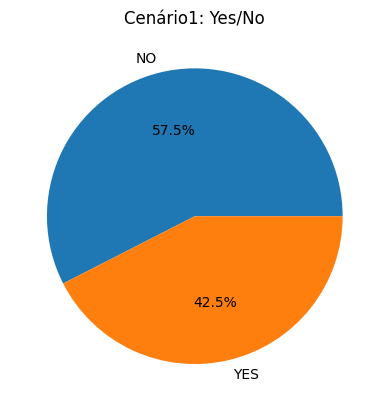

Total: 226 - Yes: 96, No: 130


In [25]:
print('Impacto arquitetural nos Issues')
show_pie_yes_no(my_df=df_issues_commits_classes_criticas_inspected, my_field='architectural_impact', my_title='Cenário1: Yes/No')

### Issues com impacto arquitetural

**96** issues

In [26]:
df_issues_com_impacto_arquitetural = df_issues_commits_classes_criticas_inspected[df_issues_commits_classes_criticas_inspected.architectural_impact=='YES']
df_issues_com_impacto_arquitetural

,issue_key,summary,issue_type,issue_status,issue_priority,description,comments,architectural_impact
0,CASSANDRA-235,Move system CFs into own Table,Sub-task,Resolved,Normal,NaN,"[""commit message for 04 reads\n\n DBManager...",YES
1,CASSANDRA-212,Range queries do not yet span multiple nodes,Bug,Resolved,Normal,Need ability to continue a query on the next n...,"[""All this needs is a bool added to RangeReply...",YES
5,CASSANDRA-71,Range query support,New Feature,Resolved,Normal,Scan for keys by range (between X and Y) or pr...,"['Add range query support, which requires usin...",YES
7,CASSANDRA-512,regression prevents recognizing local reads,Bug,Resolved,Normal,NaN,"['+1', 'committed', 'Integrated in Cassandra #...",YES
9,CASSANDRA-414,remove sstableLock,Improvement,Resolved,Normal,NaN,['rebased.\n\n02\n remove sstableLock. re-...,YES
...,...,...,...,...,...,...,...,...
218,CASSANDRA-18430,When decommissioning should set Severity to li...,Improvement,Resolved,Normal,When we are decommissioning we first set LEAVI...,['Can you rebase this to more relevant commits...,YES
219,CASSANDRA-18320,Incompatible file system thrown while running ...,Bug,Resolved,Normal,{code}\r\njava.io.UncheckedIOException\r\n\tat...,['It says that it can not recursively remove a...,YES
221,CASSANDRA-18153,Memtable being flushed without hostId in versi...,Bug,Resolved,Normal,On ticket CASSANDRA-16619 some files were chan...,"['CC [~jlewandowski]\xa0', 'Storage service is...",YES
223,CASSANDRA-18681,Internode legacy SSL storage port certificate ...,Bug,Resolved,Normal,In CASSANDRA-16666 the SSLContext cache was ch...,['4.1 [Branch|https://github.com/jonmeredith/c...,YES


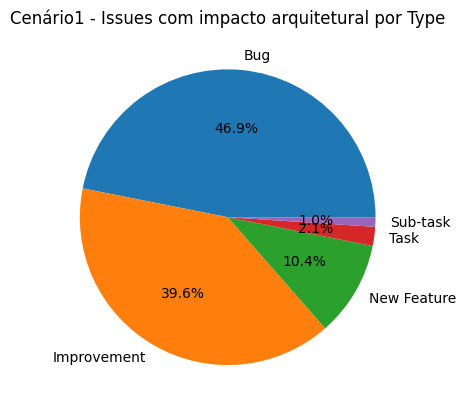

In [27]:
show_pie(my_df=df_issues_com_impacto_arquitetural, my_field='issue_type', my_title='Cenário1 - Issues com impacto arquitetural por Type')

**Commits dos issues com impacto arquitetural**

Observei que os issues com impacto arquitetural possuem commits com muitas LOCs modificadas e muitos arquivos modificados.

In [28]:
l_issue_key_com_impacto_arquitetural = df_issues_com_impacto_arquitetural.issue_key.to_list()
filtered_df_commits_com_issues_com_impacto = df_final[df_final['lista_issues'].isin(l_issue_key_com_impacto_arquitetural)]
filtered_df_commits_com_issues_com_impacto

,hahs,lista_issues,msg,m_files,date,lines,files,diff_files,diff_modified_files
9,9db8da81b7f269e5a8a7f896b751d482847d7082,CASSANDRA-71,"Add range query support, which requires using ...","['DatabaseDescriptor.java', 'ColumnFamilyStore...",29/4/2009,1456,19,"[\n {\n ""DatabaseDescriptor.java"": ""...","[\n ""@@ -114,6 +114,9 @@ service Cassandra ..."
62,5cdc75d7603d1051c9d78d6ee11dd9cd44056f44,CASSANDRA-235,move Hints cf to SYSTEM_TABLE\npatch by jbelli...,"['DatabaseDescriptor.java', 'ColumnFamilyStore...",24/6/2009,189,7,"[\n {\n ""DatabaseDescriptor.java"": ""...","[\n ""@@ -25,6 +25,8 @@\n <!-- Tables an..."
63,682736ee5ebf33ed344abd1c6e04dc408a07bfe6,CASSANDRA-235,r/m recycle cf and undocumented/incomplete Loa...,"['DatabaseDescriptor.java', 'ColumnFamilyStore...",24/6/2009,2165,18,"[\n {\n ""DatabaseDescriptor.java"": ""...","[\n ""@@ -467,12 +467,8 @@ public class Data..."
64,81dd8ee5f6e224c550bdf956e0bec3ec2c92cbee,CASSANDRA-235,use normal Table for system metadata\npatch by...,"['DatabaseDescriptor.java', 'StorageService.ja...",24/6/2009,304,8,"[\n {\n ""DatabaseDescriptor.java"": ""...","[\n ""@@ -77,7 +77,6 @@\n Keep the ..."
65,b516ce8176c4ff90f4f1696aba9315941b67f0d0,CASSANDRA-235,DBManager obscures rather than clarifies what ...,"['CassandraDaemon.java', 'StorageService.java']",24/6/2009,158,7,"[\n {\n ""CassandraDaemon.java"": ""@@ ...","[\n ""@@ -107,7 +107,7 @@ public class Callo..."
...,...,...,...,...,...,...,...,...,...
3415,4f348786bd6d72f4402134a29ddb3355b1fade61,CASSANDRA-18105,Do not remove truncated_at entry in system.loc...,['ColumnFamilyStore.java'],26/4/2023,128,3,"[\n {\n ""ColumnFamilyStore.java"": ""@...","[\n ""@@ -1,4 +1,5 @@\n 3.0.29\n+ * Do not r..."
3434,028ea02a4a877d115c748d3e179c6afb2328e430,CASSANDRA-14204,Remove unrepaired SSTables from garbage collec...,['CompactionManager.java'],4/7/2023,92,3,"[\n {\n ""CompactionManager.java"": ""@...","[\n ""@@ -1,4 +1,5 @@\n 3.11.16\n+ * Remove ..."
3435,aac070681bd01ba796814692c3fba04de103d8b4,CASSANDRA-18617,Disable the deprecated keyspace/table threshol...,"['Config.java', 'DatabaseDescriptor.java', 'St...",14/7/2023,359,18,"[\n {\n ""Config.java"": ""@@ -826,18 +...","[\n ""@@ -1,4 +1,5 @@\n 5.0\n+ * Disable the..."
3439,cde91e56f09d9ebf315c79c9a81b89f70f4eb724,CASSANDRA-18058,In-memory index implementation with query path...,"['SinglePartitionReadCommand.java', 'StorageSe...",26/7/2023,20645,244,"[\n {\n ""SinglePartitionReadCommand....","[\n ""@@ -135,5 +135,9 @@\n <groupId>d..."


In [29]:
print('Dados estatísticos das linhas modificadas e arquivos modificados ')
round(filtered_df_commits_com_issues_com_impacto.describe(), 1)

Dados estatísticos das linhas modificadas e arquivos modificados 


,lines,files
count,111.0,111.0
mean,2724.4,16.0
std,20524.6,34.8
min,1.0,1.0
25%,37.5,3.0
50%,128.0,6.0
75%,416.5,15.0
max,215675.0,244.0


### Issues sem impacto arquitetural

**130** issues

In [30]:
df_issues_sem_impacto_arquitetural = df_issues_commits_classes_criticas_inspected[df_issues_commits_classes_criticas_inspected.architectural_impact=='NO']
df_issues_sem_impacto_arquitetural

,issue_key,summary,issue_type,issue_status,issue_priority,description,comments,architectural_impact
2,CASSANDRA-173,add getPendingTasks to CFSMBean,Improvement,Resolved,Low,need to add an atomicint and inc/decr it whene...,['rebased patch as 0001-CASSANDRA-173-added-CF...,NO
3,CASSANDRA-124,NullPointerException in consistency manager af...,Bug,Resolved,Urgent,ERROR [CONSISTENCY-MANAGER:2] 2009-04-30 18:22...,"[""Shouldn't ConsistencyManager() constructor c...",NO
4,CASSANDRA-78,Interrupted recovery requires manual intervent...,Bug,Resolved,Urgent,"Originally reported by Alexander Staubo: ""If y...","[""Prashant's memory seems to be wrong here -- ...",NO
6,CASSANDRA-34,Hinted handoff rows never get deleted,Bug,Resolved,Normal,"from the list: ""after the hints are delivered,...",['Sending out hinted data needs correct RowMut...,NO
8,CASSANDRA-447,Ability to temporary set minimum and maximum c...,New Feature,Resolved,Normal,We need the ability to temporary set minimum a...,['Added the ability set/get max/min compaction...,NO
...,...,...,...,...,...,...,...,...
215,CASSANDRA-17904,Consider to not warn about deprecated properti...,Improvement,Resolved,Low,When there is an initialisation of database de...,['Kindly pinging [~e.dimitrova] to raise aware...,NO
217,CASSANDRA-17868,"Allow disabling hotness persistence, or tuning...",Improvement,Resolved,Normal,The persisting of the sstables hotness when th...,['||Item|Link||\r\n|PR|[link|https://github.co...,NO
220,CASSANDRA-18219,Warning message on aggregation queries doesn't...,Improvement,Resolved,Normal,The existing aggregation query warning message...,['Thank you for reporting this! I will take a ...,NO
222,CASSANDRA-18697,Skip ColumnFamilyStore#topPartitions initializ...,Bug,Resolved,Normal,In {{org.apache.cassandra.db.ColumnFamilyStore...,['CI: [https://app.circleci.com/pipelines/gith...,NO


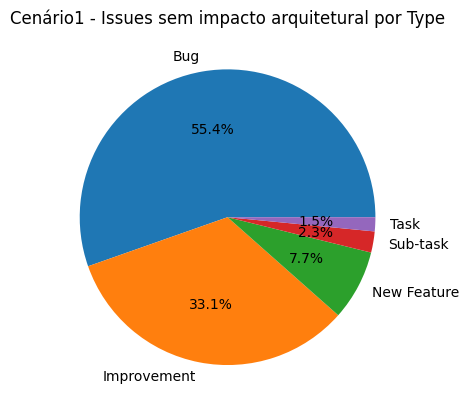

In [31]:
show_pie(my_df=df_issues_sem_impacto_arquitetural, my_field='issue_type', my_title='Cenário1 - Issues sem impacto arquitetural por Type')

**Commits dos issues sem impacto arquitetural**

Observei que os issues sem impacto arquitetural possuem commits com poucas LOCs modificadas e poucos arquivos modificados.

In [32]:
l_issue_key_sem_impacto_arquitetural = df_issues_sem_impacto_arquitetural.issue_key.to_list()
filtered_df_commits_com_issues_sem_impacto = df_final[df_final['lista_issues'].isin(l_issue_key_sem_impacto_arquitetural)]
filtered_df_commits_com_issues_sem_impacto

,hahs,lista_issues,msg,m_files,date,lines,files,diff_files,diff_modified_files
13,bbe89e795bbc631c2b626766840d943498304630,CASSANDRA-124,do not leave variables uninitialized in Consis...,['StorageService.java'],4/5/2009,22,2,"[\n {\n ""StorageService.java"": ""@@ -...","[\n ""@@ -145,16 +145,18 @@ class Consistenc..."
14,f70a5a0c8cff203b17285494fbbd99176bbee649,CASSANDRA-78,clean up anticompaction code a little.\npatch ...,['ColumnFamilyStore.java'],4/5/2009,43,2,"[\n {\n ""ColumnFamilyStore.java"": ""@...","[\n ""@@ -1027,8 +1027,6 @@ public class Col..."
20,fce0ee0d7b89576c7f49c2f24a90e8f26e10314a,CASSANDRA-34,This changeset abstracts the logic for placing...,['ColumnFamilyStore.java'],5/5/2009,126,3,"[\n {\n ""ColumnFamilyStore.java"": ""@...","[\n ""@@ -402,11 +402,9 @@ public class Colu..."
21,7779df6ce4633752a0f6768da94627aee2162103,CASSANDRA-34,This patch adds ColumnFamilyStore.forceflush t...,['ColumnFamilyStore.java'],5/5/2009,7,2,"[\n {\n ""ColumnFamilyStore.java"": ""@...","[\n ""@@ -425,7 +425,7 @@ public class Colum..."
22,f17487c541dfae03858ae703015d4049094a0f55,CASSANDRA-34,A make hint generation include a real timestam...,['ColumnFamilyStore.java'],5/5/2009,96,3,"[\n {\n ""ColumnFamilyStore.java"": ""@...","[\n ""@@ -641,7 +641,7 @@ public class Colum..."
...,...,...,...,...,...,...,...,...,...
3363,4c85c6a4030d7d613230cd4b2204c42f941fd552,CASSANDRA-17904,"key_cache_save_period, row_cache_save_period, ...",['Config.java'],19/9/2022,10,3,"[\n {\n ""Config.java"": ""@@ -434,19 +...","[\n ""@@ -1,4 +1,5 @@\n 4.1-alpha2\n+ * We s..."
3399,b8494a82751ae2d31ab0f36412f7eacdcc1c3774,CASSANDRA-18219,Log warning message on aggregation queries wit...,['SelectStatement.java'],7/2/2023,8,2,"[\n {\n ""SelectStatement.java"": ""@@ ...","[\n ""@@ -1,4 +1,5 @@\n 4.0.8\n+ * Log warni..."
3419,b8e21fb80afa6696374292dc99a480fac9788e64,CASSANDRA-14319,Validate the existence of a datacenter in node...,['StorageService.java'],17/5/2023,68,3,"[\n {\n ""StorageService.java"": ""@@ -...","[\n ""@@ -1,4 +1,5 @@\n 3.0.30\n+ * Validate..."
3448,9c796dfb272daa3ce57a2dc5cbeadd9273e1ac72,CASSANDRA-18697,Skip ColumnFamilyStore#topPartitions initializ...,['ColumnFamilyStore.java'],1/8/2023,98,3,"[\n {\n ""ColumnFamilyStore.java"": ""@...","[\n ""@@ -1,4 +1,5 @@\n 4.1.4\n+ * Skip Colu..."


In [33]:
print('Dados estatísticos das linhas modificadas e arquivos modificados ')
round(filtered_df_commits_com_issues_sem_impacto.describe(), 1)

Dados estatísticos das linhas modificadas e arquivos modificados 


,lines,files
count,147.0,147.0
mean,233.6,7.8
std,544.0,12.5
min,1.0,1.0
25%,12.0,2.0
50%,68.0,3.0
75%,192.0,8.0
max,3841.0,93.0
